# Inicio

In [32]:
import numpy as np
import pandas as pd
import os
import pickle
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio

import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [33]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [29]:
def LPC3janelas(s, fa):
    N = s.shape[0]
    Janela = int(np.round(N/3))
    marcas = [0, int(np.round((N-Janela)/2))-1, N-Janela]
    Ordem = int(np.round(0.003*fa))
    CP = np.zeros((Ordem,3))
    S = np.zeros((Janela-Ordem-1,Ordem+1))
    cont = 0
    for k in marcas:
        saux = s[k:k+Janela]
        for m in range(Ordem+1):
            S[:,m] = saux[m:m-Ordem-1]
        C = np.linalg.pinv(S[:,:-1]).dot(S[:,-1])
        CP[:,cont] = C
        cont += 1
    return CP

In [30]:
def CP2vec(CP, fa):
    w = np.arange(5000/fa*np.pi, 50/fa*np.pi, -100/fa*np.pi)
    P = np.zeros((len(w), CP.shape[1]))
    for k in range(CP.shape[1]):
        h = np.hstack((1, -np.flipud(CP[:,k])))
        for i in range(len(w)):
            P[i,k] = abs(1/np.sum(np.exp(-1j*w[i]*np.arange(len(h)))*h))
    P = np.log10(P/P.max() + 0.01) + 2
    P = P.flatten(order='F')/np.sqrt(np.sum(P.flatten()**2))
    return P

In [5]:
pasta = '/content/base'
arqs = os.listdir(pasta)

In [7]:
fs, s = wavfile.read(pasta + '/' + arqs[0])
print(arqs[0])
Audio(s,rate=fs)

m5.wav


In [8]:
aux = []
for arq in tqdm(arqs):
    fs, s = wavfile.read(pasta + '/' + arq)
    CP = LPC3janelas(s, fs)
    P = CP2vec(CP, fs)
    aux.append(P)

100%|██████████| 10/10 [00:00<00:00, 28.06it/s]


In [ ]:
rotulos = [i[0] for i in arqs]
letras = np.unique(rotulos)
inds = [np.where(letras == i)[0][0] for i in rotulos]
y = np.zeros((len(rotulos), len(letras)))
y[np.arange(len(rotulos)), inds] = 1

In [ ]:
X = np.array(aux)

In [ ]:
class mlp(nn.Module):
    def __init__(self, raw_dim, dim1, dim2):
        super().__init__()
        self.all_layers = torch.nn.Sequential(
            # Encoder
            nn.Flatten(start_dim=1),
            nn.Linear(raw_dim, dim1),
            nn.Tanh(),
            nn.Linear(dim1, dim2),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device).detach()
X_test = torch.tensor(X_test, dtype=torch.float32, device=device).detach()
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).detach()
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).detach()
N = X_train.shape[0]

In [ ]:
raw_dim = 150
dim1 = 150
dim2 = letras.shape[0]
model = mlp(raw_dim, dim1, dim2).to(device)
batch_size = 128
summary(model, (150,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 150]               0
            Linear-2                  [-1, 150]          22,650
              Tanh-3                  [-1, 150]               0
            Linear-4                   [-1, 18]           2,718
Total params: 25,368
Trainable params: 25,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [ ]:
!pip install torcheval

In [11]:
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50
batch_size = 128
batch_start = torch.arange(0, N, batch_size)
trainLoss = []
valLoss = []

for epoch in range(n_epochs):
    model.train()
    inds = np.random.permutation(N)
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[inds,:][start:start+batch_size,:]
            y_batch = y_train[inds,:][start:start+batch_size,:]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(loss=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    y_pred = nn.functional.softmax(y_pred, dim=1)
    inds = y_pred.argmax(dim=1)
    target = y_test.argmax(dim=1)
    valLoss.append(float(multiclass_f1_score(inds, target, num_classes=18)))
    # valLoss.append(float(loss_fn(y_pred, y_test)))
    y_pred = model(X_train)
    trainLoss.append(float(loss_fn(y_pred, y_train)))
fig = go.Figure()
fig.add_trace(go.Scatter(y=valLoss, mode="lines", showlegend=True, name='validação'))
fig.add_trace(go.Scatter(y=trainLoss, mode="lines", showlegend=True, name='treino'))
fig.show()

Epoch 49: 100%|██████████| 14/14 [00:00<00:00, 89.20batch/s, loss=0.113]


# Novas funções

In [34]:
def segmentador(x, fa):
    sigma = np.sqrt(np.sum(x**2)/len(x))
    x = x/sigma
    p = x**2
    pf = np.zeros(len(p))
    pf[0] = 2
    alfa = 1-10**(-3/(0.5*fa))
    pini = []
    pfim = []
    dentro = False
    for k in range(1, len(x)):
        if p[k] > pf[k-1]:
            pf[k] = 100*alfa*p[k] + (1-100*alfa)*pf[k-1]
        else:
            pf[k] = alfa*p[k] + (1-alfa)*pf[k-1]
        if not dentro:
            if (pf[k] > 2) and (pf[k-1] <= 2):
                pini.append(k-1)
                dentro = True
        if dentro:
            if (pf[k] < 1.5) and (pf[k-1] >= 1.5):
                pfim.append(k-1)
                dentro = False
    Ndelta = min(len(pini), len(pfim))
    pini = pini[:Ndelta]
    pfim = pfim[:Ndelta]
    delta = np.array(pfim) - np.array(pini)
    pp = np.where(delta >= 0.1*fa)[0]
    pini = np.array(pini)[pp]
    pfim = np.array(pfim)[pp]
    return pini, pfim

In [35]:
arqs = os.listdir()
arqs

['.config', '8d68c486-1aac-4f6f-af3b-b56d270d37b5.wav', 'sample_data']

In [36]:
fs, s = wavfile.read(arqs[1])
print(arqs[1])
Audio(s,rate=fs)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
pini, pfim = segmentador(s, fs)
pini, pfim

(array([    936,  295668,  320671,  326662,  733085, 1225925, 1286766,
        1291943, 1348066, 1371640, 1400362, 1502348, 1532584, 1592694,
        1691037, 1726302, 1765647, 1805324, 1818243, 1841421, 1854368,
        1867132, 1876985, 2005161, 2062263, 2109843, 2131735, 2160889,
        2228640, 2422430, 2456187, 2504120, 2814856]),
 array([ 286818,  313228,  325494,  733041, 1205257, 1238564, 1291733,
        1300273, 1353969, 1395415, 1477069, 1507433, 1574385, 1683629,
        1720111, 1745244, 1801210, 1815722, 1832430, 1851817, 1865404,
        1873179, 1994855, 2036608, 2075284, 2126728, 2140765, 2212960,
        2419663, 2455634, 2502185, 2813092, 2821025]))

In [38]:
import matplotlib.pyplot as plt

In [39]:
i = 0
Audio(s[pini[i]:pfim[i]],rate=fs)

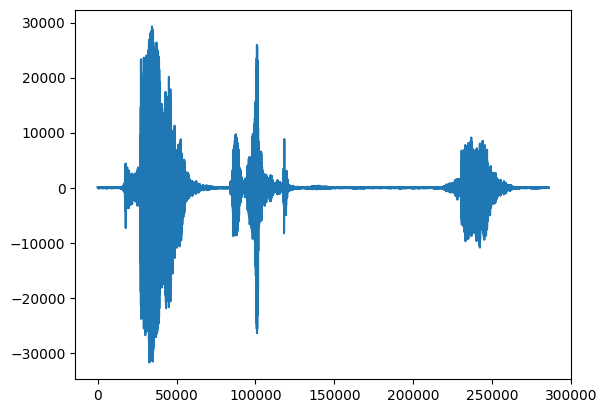

In [40]:
plt.plot(s[pini[i]:pfim[i]])

In [41]:
def SpecLPC(s,fa):
    N = len(s)
    Janela = int(np.round(0.02*fa))
    marcas = np.arange(0, N-Janela+1, int(np.round((0.5*Janela))))
    Ordem = int(np.round(0.002*fa))
    CP = np.zeros((Ordem,len(marcas)))
    S = np.zeros((Janela-Ordem,Ordem+1))
    cont = 0
    PotEr = np.zeros(len(marcas))
    F0 = np.zeros(len(marcas))
    for k in tqdm(marcas):
        saux = s[k:k+Janela]
        for m in range(Ordem+1):
            S[:,m] = saux[m:Janela-Ordem+m]
        C = np.linalg.pinv(S[:,:-1]).dot(S[:,-1])
        CP[:,cont] = C
        PotEr[cont] = np.sum(S[:,-1]**2)/S.shape[0]
        v = saux
        v = v/np.max(np.abs(v))
        v[np.abs(v)<0.05] = 0
        R = np.zeros(200)
        for j in range(30, 200):
            R[j] = np.sum(v[:-j]*v[j:])/np.sum(v[:-j]**2)
        periodo = np.argmax(R)
        if periodo < 32 or periodo > 320:
            F0_inst = 0
        else:
            F0_inst = fa/(periodo+1)
        F0[cont] = F0_inst
        cont = cont +1
    w = np.arange((5000/fa)*np.pi, (100/fa)*np.pi, (-125/fa)*np.pi)
    P = np.zeros((len(w), CP.shape[1]))
    for k in range(CP.shape[1]):
        h = np.hstack((1, -np.flipud(CP[:,k])))
        for i in range(len(w)):
            P[i,k] = np.abs(1/np.sum(np.exp(-1j*w[i]*np.arange(len(h)))*h))
    F0[F0<80] = 0
    P = np.log10(P/np.max(P) + 0.01) + 2
    return P, F0, PotEr

In [13]:
P, F0, PotEr = SpecLPC(s[pini[i]:pfim[i]], fs)

100%|██████████| 594/594 [00:15<00:00, 37.86it/s]


In [42]:
def sinal2padrao(x, fa):
    P,F0,Pot = SpecLPC(x, fa)
    pp = np.where(F0 > 80)[0]
    if len(pp) > 0:
        F0Medio = np.sum(F0[pp])/len(pp)
    else:
        F0Medio = 0
    PotMedia = np.sum(Pot)/len(Pot)
    terco = int(np.round(P.shape[1]/3))
    vetor = np.hstack((np.sum(P[:,:terco], axis=1), np.sum(P[:,terco:2*terco], axis=1), np.sum(P[:,2*terco:], axis=1)))
    padrao = vetor/np.max(vetor)
    return padrao, F0Medio, PotMedia, P, F0, Pot

In [43]:
padrao, F0Medio, PotMedia, P, F0, Pot = sinal2padrao(s[pini[i]:pfim[i]], fs)

100%|██████████| 594/594 [00:12<00:00, 48.17it/s]


In [60]:
def geraFrases(S):
    q = np.array([""]*S.shape[0])
    frase = [""]*S.shape[1]
    for col in range(S.shape[1]):
        pp = np.where(S[:,col] > 0.5)[0]
        q[pp] = "a"
        pp = np.where(S[:,col] <= 0.5)[0]
        q[pp] = "b"
        frase[col] = ''.join(q)
    return frase

In [76]:
def cardinalidadeEfetiva(frase):
    U = np.unique(frase)
    h = np.zeros(len(U))
    for k in range(len(U)):
        h[k] = np.sum(np.array(frase) == U[k])
    h = h/(np.sum(h) + np.finfo(float).eps)
    C = 2**(-np.sum(h*np.log2(h + np.finfo(float).eps)))
    return C

In [78]:
S, F0, PotEr = SpecLPC(s[pini[i]:pfim[i]], fs)
S = S/np.max(S, axis=1, keepdims=True)
Z = np.stack((np.sum(S[:10,:], axis=0), np.sum(S[10:20,:], axis=0), np.sum(S[20:30,:], axis=0), np.sum(S[30:40,:], axis=0)), axis=0)
Z = Z/np.max(Z, axis=1, keepdims=True)
frase = geraFrases(Z)
cardinalidadeEfetiva(frase)

100%|██████████| 594/594 [00:11<00:00, 51.00it/s]


2.5510825369187886

In [85]:
def autocorPos(v, Nmin, Nmax):
    R = np.zeros(Nmax)
    for j in range(Nmin, Nmax):
        R[j] = np.sum(v[:-j]*v[j:])/np.sum(v[:-j]**2)
    return R

In [114]:
def viterbi(s,fa):
    N = len(s)
    Janela = int(round(0.02*fa))
    marcas = np.arange(0, N-Janela+1, int(round((0.5*Janela))))
    T = len(marcas)
    Pot = np.zeros(T)
    F0 = np.zeros(T)
    Nmin = int(round(fa/500))
    Nmax = int(round(fa/80))
    A = np.zeros((Nmax, Nmax))
    for k in range(Nmax):
        for m in range(Nmax):
            A[k,m]  = np.exp(-(k-m)**2/200)
    A = A/np.sum(A, axis=1, keepdims=True)
    estadoAnterior = np.zeros((Nmax, T))
    maxVero = np.zeros((Nmax, T))
    R = np.zeros((Nmax, T))
    cont = 0
    k = marcas[0]
    v = s[k:k+Janela]
    Pot[cont] = np.sum(v**2)/Janela
    R[:,cont] = autocorPos(v, Nmin, Nmax)
    maxVero[:,cont] = R[:,cont]/np.sum(R[:,cont])
    cont += 1
    for k in tqdm(marcas[1:]):
        v = s[k:k+Janela]
        Pot[cont] = np.sum(v**2)/Janela
        R[:,cont] = autocorPos(v, Nmin, Nmax)
        maxVero[:,cont] = R[:,cont]/np.sum(R[:,cont])
        for estado in range(Nmax):
            aux = A[:,estado]*(maxVero[:,cont-1]*maxVero[estado,cont])
            pos = np.argmax(aux)
            maxVero[estado,cont] = aux[pos]
            estadoAnterior[estado,cont] = pos
        maxVero[:,cont] = maxVero[:,cont]/np.sum(maxVero[:,cont])
        cont += 1
    estadoEstimado = np.zeros(T, dtype=int)
    maxCor = np.zeros(T)
    estadoEstimado[-1] = np.argmax(maxVero[:,-1])
    maxCor[-1] = R[estadoEstimado[-1],-1]*Janela/(Janela - estadoEstimado[-1])
    margemA = np.max([1,estadoEstimado[-1]-1])
    margemB = np.min([estadoEstimado[-1]+1,Nmax])
    w = R[margemA:margemB,-1]
    w = w/np.sum(w)
    periodo = np.sum(w*np.arange(margemA,margemB))
    if periodo <= Nmax and periodo >= Nmin:
        F0[-1] = fa/periodo
    for t in range(T-1,0,-1):
        estadoEstimado[t-1] = estadoAnterior[estadoEstimado[t],t]
        maxCor[t-1] = R[estadoEstimado[t-1],t-1]*Janela/(Janela - estadoEstimado[t-1])
        margemA = np.max([1,estadoEstimado[t-1]-1])
        margemB = np.min([estadoEstimado[t-1]+1,Nmax])
        w = R[margemA:margemB,t-1]
        w = w/np.sum(w)
        periodo = np.sum(w*np.arange(margemA,margemB))
        if periodo <= Nmax and periodo >= Nmin:
            F0[t-1] = fa/periodo
    return F0, Pot, maxCor

In [115]:
F0, Pot, maxCor = viterbi(s1, fs)

100%|██████████| 593/593 [00:11<00:00, 50.53it/s]


In [118]:
Audio(s[pini[i]:pfim[i]],rate=fs)

In [120]:
px.line(Pot)

In [117]:
px.line(F0)

In [119]:
px.line(s1)

Output hidden; open in https://colab.research.google.com to view.